In [40]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow import keras

from transformers import TFBertModel

import re
import nltk
from nltk.corpus import stopwords
sw = stopwords.words('english')

# Initial EDA

In [4]:
# Reading in dataset
import pandas as pd
all_data = pd.read_csv("winemag-data-130k-v2.csv")
all_data.shape

(129971, 14)

There are 129,971 wine reviews on our data set.

In [5]:
all_data.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [6]:
# Using just the description and variety of wine
dv_data = all_data[['description', 'variety']]
dv_data.head()

,description,variety
0,"Aromas include tropical fruit, broom, brimston...",White Blend
1,"This is ripe and fruity, a wine that is smooth...",Portuguese Red
2,"Tart and snappy, the flavors of lime flesh and...",Pinot Gris
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir


In [7]:
# Top 10 most reviewed varieties
variety_count = dv_data.variety.value_counts()
variety_count.head(10), len(variety_count)

(Pinot Noir                  13272
 Chardonnay                  11753
 Cabernet Sauvignon           9472
 Red Blend                    8946
 Bordeaux-style Red Blend     6915
 Riesling                     5189
 Sauvignon Blanc              4967
 Syrah                        4142
 Rosé                         3564
 Merlot                       3102
 Name: variety, dtype: int64,
 707)

There are 707 different varieties of wine in our data set.

In [8]:
# Selecting wine reviews for top 10 varieties only
variety_mask = dv_data['variety'].isin(variety_count.index[:10])
data = dv_data[variety_mask]
data.head()

,description,variety
3,"Pineapple rind, lemon pith and orange blossom ...",Riesling
4,"Much like the regular bottling from 2012, this...",Pinot Noir
10,"Soft, supple plum envelopes an oaky structure ...",Cabernet Sauvignon
12,"Slightly reduced, this wine offers a chalky, t...",Cabernet Sauvignon
14,Building on 150 years and six generations of w...,Chardonnay


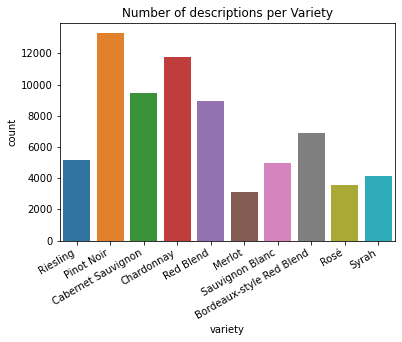

In [9]:
chart = sns.countplot(data.variety)
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [10]:
# Merlot is the variety of wine with the least amount of reviews in our dataset
print("Number of Merlot reviews:", sum(data['variety'] == "Merlot"))

Number of Merlot reviews: 3102


In [11]:
# Sampling reviews of the top 10 varieties to create a uniform dataset
df = data[data['variety'] == 'Merlot']
for i in variety_count.index[:9]:
    df = df.append(data[data['variety'] == i].sample(n=sum(data['variety'] == "Merlot"), random_state = 32))

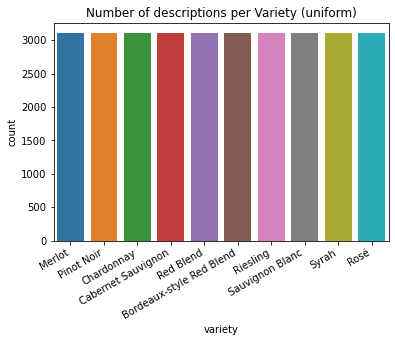

In [12]:
chart = sns.countplot(df.variety)
plt.title("Number of descriptions per Variety (uniform)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [45]:
text = " ".join(review for review in dv_data['description'])

In [46]:
# Generate a word cloud image
wordcloud = WordCloud(stopwords=sw, background_color="white").generate(text)

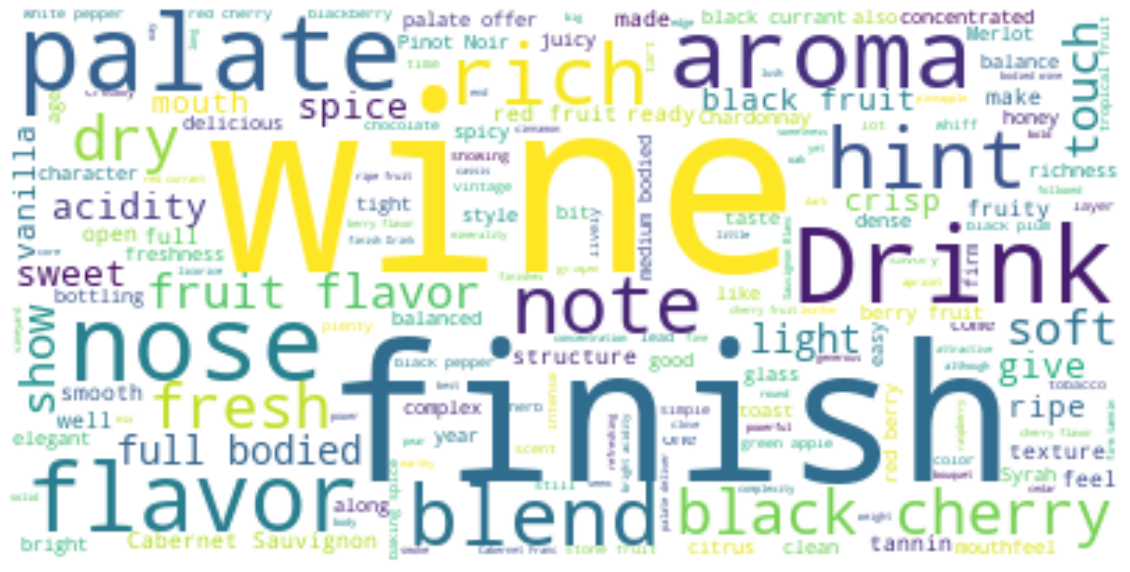

In [47]:
plt.figure(figsize=[20,20])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Data Preprocessing


In [13]:
input_data = df['description']

In [14]:
input_data = input_data.str.lower()

In [15]:
list_aux = []
for phase_word in input_data:
    list_aux.append(' '.join([re.sub('[0-9\W_]', '', word) for word in phase_word.split() if not word in sw]))
input_data = list_aux

In [16]:
# Integer encode variety labels
label_encoder = LabelEncoder()
variety_encoded = label_encoder.fit_transform(df.variety)

In [22]:
classes = label_encoder.classes_

In [17]:
countVectorizer = CountVectorizer()
input_data = countVectorizer.fit_transform(input_data)

In [18]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(input_data, variety_encoded, test_size = 0.25, random_state = 88)

In [19]:
X_train.sort_indices()
X_test.sort_indices()

In [20]:
train_df = pd.DataFrame({'text': X_train, 'labels': y_train})
test_df = pd.DataFrame({'text': X_test, 'labels': y_test})

# Building the Models

### Logistic Regression (Baseline)

In [23]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.750354609929078


/home/jupyter/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=classes))

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.76      0.77      0.77       786
      Cabernet Sauvignon       0.61      0.62      0.61       778
              Chardonnay       0.81      0.82      0.81       793
                  Merlot       0.60      0.61      0.60       771
              Pinot Noir       0.72      0.69      0.70       747
               Red Blend       0.76      0.70      0.73       778
                Riesling       0.88      0.90      0.89       772
                    Rosé       0.86      0.86      0.86       780
         Sauvignon Blanc       0.81      0.81      0.81       778
                   Syrah       0.70      0.72      0.71       772

                accuracy                           0.75      7755
               macro avg       0.75      0.75      0.75      7755
            weighted avg       0.75      0.75      0.75      7755



In [25]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

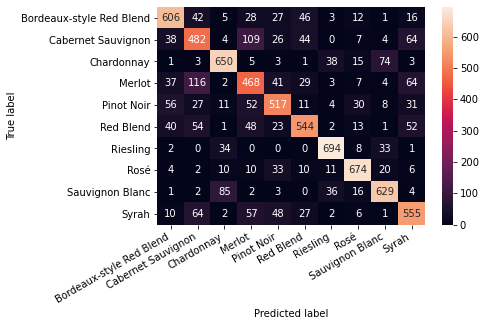

In [26]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

### Neural Net 

In [27]:
model = keras.Sequential()
model.add(keras.layers.Dense(100, activation='relu', input_dim=len(countVectorizer.get_feature_names())))
model.add(keras.layers.Dense(units=variety_encoded.max()+1, activation='softmax'))
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=keras.optimizers.Adam(1e-5), 
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, verbose=1)
history

Epoch 1/150
728/728 [==============================] - 4s 5ms/step - loss: 2.2917 - acc: 0.1415 - val_loss: 2.2493 - val_acc: 0.2896
Epoch 2/150
728/728 [==============================] - 3s 4ms/step - loss: 2.2261 - acc: 0.3632 - val_loss: 2.1646 - val_acc: 0.4615
Epoch 3/150
728/728 [==============================] - 3s 4ms/step - loss: 2.1309 - acc: 0.5118 - val_loss: 2.0621 - val_acc: 0.5403
Epoch 4/150
728/728 [==============================] - 3s 4ms/step - loss: 2.0216 - acc: 0.5801 - val_loss: 1.9591 - val_acc: 0.5863
Epoch 5/150
728/728 [==============================] - 3s 4ms/step - loss: 1.9122 - acc: 0.6283 - val_loss: 1.8611 - val_acc: 0.6165
Epoch 6/150
728/728 [==============================] - 3s 4ms/step - loss: 1.8073 - acc: 0.6643 - val_loss: 1.7689 - val_acc: 0.6411
Epoch 7/150
728/728 [==============================] - 3s 4ms/step - loss: 1.7151 - acc: 0.6867 - val_loss: 1.6820 - val_acc: 0.6556
Epoch 8/150
728/728 [==============================] - 3s 4ms/step - 

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2234000   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 2,235,010
Trainable params: 2,235,010
Non-trainable params: 0
_________________________________________________________________


In [31]:
y_pred = model.predict(X_test).argmax(axis=-1)
print(classification_report(y_test, y_pred, target_names=classes))

                          precision    recall  f1-score   support

Bordeaux-style Red Blend       0.77      0.78      0.78       786
      Cabernet Sauvignon       0.60      0.62      0.61       778
              Chardonnay       0.82      0.83      0.83       793
                  Merlot       0.59      0.61      0.60       771
              Pinot Noir       0.74      0.71      0.72       747
               Red Blend       0.78      0.72      0.75       778
                Riesling       0.90      0.90      0.90       772
                    Rosé       0.88      0.87      0.87       780
         Sauvignon Blanc       0.82      0.82      0.82       778
                   Syrah       0.69      0.73      0.71       772

                accuracy                           0.76      7755
               macro avg       0.76      0.76      0.76      7755
            weighted avg       0.76      0.76      0.76      7755



In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

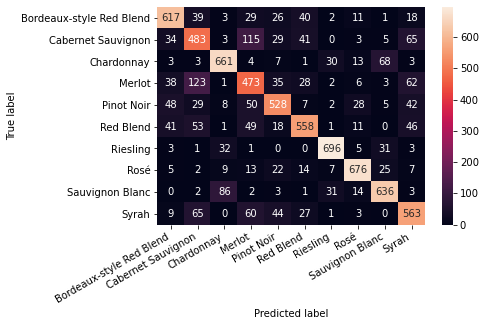

In [33]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

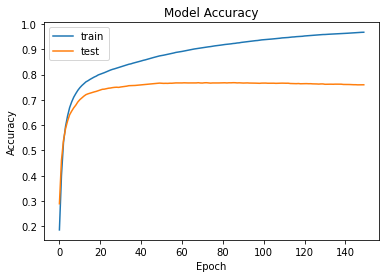

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


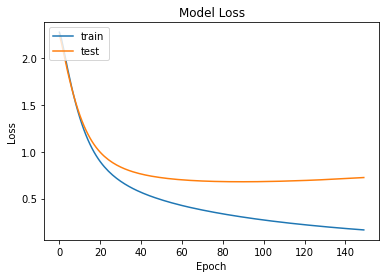

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Custom Input Prediction

In [35]:
d = {'description': ['Strawberry and crisper tasting notes', 
                     'Hint of blackberry and vanilla flavor']}
df = pd.DataFrame(data=d)
input_data = df['description']
input_data = input_data.str.lower()
list_aux = []
for phase_word in input_data:
    list_aux.append(' '.join([re.sub('[0-9\W_]', '', word) for word in phase_word.split() if not word in sw]))
input_data = list_aux
inputs = countVectorizer.transform(input_data)
inputs

<2x22339 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [36]:
label_encoder.inverse_transform(model.predict(inputs).argmax(axis= -1))

array(['Rosé', 'Cabernet Sauvignon'], dtype=object)

### Wine Variety Vocabulary

In [139]:
from string import punctuation


def get_top_counts(X, vec):
    counts = np.array(np.sum(X, axis=0))[0]
    vocab_inv = {k: counts[v] for k, v in vec.vocabulary_.items()}
    return vocab_inv

def get_most_common(counts_dict, n=None):
    words = np.array(list(counts_dict.keys()))
    counts = np.array(list(counts_dict.values()))
    
    counts_sorted_idx = np.argsort(counts)[::-1]
    if n:
        counts_sorted_idx = counts_sorted_idx[:n]
        
    return words[counts_sorted_idx], counts[counts_sorted_idx]
normal_stopwords = nltk.corpus.stopwords.words('english')
top_domain_specific_words = []
n = 10

vec = CountVectorizer(
    lowercase=True,
    stop_words=normal_stopwords,
    ngram_range=(1, 1,),
    min_df=10
)
X =  vec.fit_transform(data['description'])

temp_counts = get_top_counts(X, vec)
most_common_words, most_common_counts = get_most_common(temp_counts, n=n)
        
stop_words = list(most_common_words) + normal_stopwords + list(punctuation)
stop_words = set(stop_words)

In [140]:
def get_vec(data, **kwargs):
    vec = CountVectorizer(
        lowercase=True,
        stop_words=stop_words,
        **kwargs
    )
    return vec.fit_transform(data), vec
        
def print_top_counts(X, vec, title='Top Counts', n=10):
    vocab_counts = get_top_counts(X, vec)
    
    vocab, counts = get_most_common(vocab_counts, n=n)
    print(title)
    for v, c in zip(vocab, counts):
        print(f'\t{v}: {c}')

In [142]:
varieties = variety_count.index[:10]
variety_vocabs = {}
for i in varieties:
    variety_descriptions = data[data['variety'] == i]['description']
    variety_vocabs[i] = get_vec(variety_descriptions, ngram_range=(1,1))

In [146]:
white_variety = ['Sauvignon Blanc', 'Chardonnay']
n = 10
for name in white_variety:
    variety_X, vec = variety_vocabs[name]
    print_top_counts(variety_X, vec, title=f'{name} counts:', n=n)

Sauvignon Blanc counts:
	green: 1483
	citrus: 1443
	sauvignon: 1314
	blanc: 1189
	crisp: 1129
	drink: 1046
	lime: 1034
	grapefruit: 987
	fresh: 930
	ripe: 898
Chardonnay counts:
	apple: 3926
	chardonnay: 3315
	oak: 2877
	ripe: 2811
	drink: 2459
	lemon: 2298
	pear: 2193
	crisp: 2112
	rich: 2110
	vanilla: 1992


In [145]:
red_variety = ['Merlot', 'Cabernet Sauvignon']
n = 10
for name in red_variety:
    variety_X, vec = variety_vocabs[name]
    print_top_counts(variety_X, vec, title=f'{name} counts:', n=n)

Merlot counts:
	merlot: 1287
	red: 772
	plum: 688
	oak: 646
	soft: 542
	spice: 493
	berry: 484
	ripe: 480
	dry: 478
	notes: 464
Cabernet Sauvignon counts:
	cabernet: 3170
	oak: 2624
	blackberry: 2430
	cassis: 1710
	drink: 1585
	chocolate: 1564
	ripe: 1526
	red: 1480
	plum: 1467
	currant: 1454
